In [ ]:
import igraph as ig
import random
import pandas as pd
import json
from collections import defaultdict

def agent_based_model_simulation(
    network,
    initial_diseased_nodes,
    drug_targets,
    disease_spread_prob=0.1,
    drug_efficacy_prob=0.5,
    num_steps=100,
    latency_period=1,
    synergy_factor=1.2
):
    """
    Simulates the spread of disease and the effect of drug targeting on a PPI network
    with added complexities:
      - Node-specific susceptibility
      - Edge-specific transmission
      - Latent and diseased states
      - Drug synergy if multiple drugs affect the same node repeatedly

    Parameters
    ----------
    network : ig.Graph
        An igraph Graph representing the PPI network.
        Expected to have:
           - vs['name'] : each node’s name
           - vs['susceptibility'] (optional, default=1.0 if not present)
           - es['transmission'] (optional, default=1.0 if not present)
    Returns
    -------
    df : pandas.DataFrame
        A DataFrame with columns: step, node, state
    """

    print("Starting Enhanced ABM simulation...")

    # -------------------------------------------------------------------------
    # 0. Prepare node states and parameters
    # -------------------------------------------------------------------------
    default_susceptibility = 1.0
    if "susceptibility" not in network.vertex_attributes():
        # If no susceptibility is provided, use 1.0 for all
        network.vs["susceptibility"] = [default_susceptibility] * network.vcount()

    default_transmission = 1.0
    if "transmission" not in network.edge_attributes():
        # If no transmission is provided, use 1.0 for all
        network.es["transmission"] = [default_transmission] * network.ecount()


    # Each node also has a “latent_counter” to track how many steps it has been latent.
    # Once it reaches latency_period, it transitions to “diseased.”

    node_states = {}
    latent_counter = defaultdict(int)  # how many steps a node has been latent

    for v in network.vs:
        node_name = v["name"]
        if node_name in initial_diseased_nodes:
            node_states[node_name] = "diseased"
        else:
            node_states[node_name] = "healthy"

    history = {0: node_states.copy()}
    print(f"Initial diseased nodes count: {sum(s == 'diseased' for s in node_states.values())}")

    # To track synergy usage per step (simple example: count how many times a node is targeted in a step)
    drug_exposure_counter = defaultdict(int)

    # -------------------------------------------------------------------------
    # 1. Main Simulation Loop
    # -------------------------------------------------------------------------
    for step in range(1, num_steps + 1):
        print(f"\n--- ABM Step {step} ---")
        previous_states = history[step - 1]
        new_states = previous_states.copy()

        # Clear counters for synergy in each new step
        drug_exposure_counter.clear()

        # Shuffle node order to avoid bias
        nodes_list = list(network.vs['name'])
        random.shuffle(nodes_list)

        # For logging
        nodes_becoming_diseased_this_step = 0
        nodes_becoming_latent_this_step = 0
        nodes_recovered_this_step = 0

        # Step 1a: Update latent -> diseased transitions
        for node_name in nodes_list:
            if previous_states[node_name] == "latent":
                latent_counter[node_name] += 1
                if latent_counter[node_name] >= latency_period:
                    new_states[node_name] = "diseased"

        # Step 1b: Disease spread from diseased neighbors
        for node_name in nodes_list:
            current_state = previous_states[node_name]
            if current_state == "healthy":
                # Check neighbors
                idx_node = network.vs.find(name=node_name).index
                neighbor_ids = network.neighbors(idx_node, mode="all")

                # Probability of becoming infected is 1 - product(1 - infection_from_each_diseased_neighbor)
                # We do a loop so we can incorporate synergy or advanced logic.
                infection_probability = 0.0

                for edge_id in network.incident(idx_node, mode="all"):
                    edge = network.es[edge_id]
                    beta_e = edge["transmission"]  # edge-specific
                    source_idx = edge.tuple[0] if edge.tuple[0] != idx_node else edge.tuple[1]
                    source_node_name = network.vs[source_idx]["name"]

                    if previous_states[source_node_name] == "diseased":
                        # Probability to infect node_name from this neighbor
                        alpha_n = network.vs[idx_node]["susceptibility"]
                        p_infect_from_this_edge = disease_spread_prob * alpha_n * beta_e
                        # Combine infection probabilities from multiple diseased neighbors
                        infection_probability = 1 - (1 - infection_probability) * (1 - p_infect_from_this_edge)

                # If final infection prob > random => the node becomes latent
                if random.random() < infection_probability:
                    new_states[node_name] = "latent"
                    latent_counter[node_name] = 0  # reset latent counter
                    nodes_becoming_latent_this_step += 1

        # Step 1c: Apply drug targets
        # If node is diseased or latent and is in drug_targets => chance to recover
        # We'll keep it simple: synergy if a node is targeted multiple times in repeated steps.
        for node_name in nodes_list:
            current_state = new_states[node_name]

            if node_name in drug_targets and current_state in ["diseased", "latent"]:
                drug_exposure_counter[node_name] += 1
                # synergy effect
                local_drug_efficacy = drug_efficacy_prob * (synergy_factor ** (drug_exposure_counter[node_name] - 1))
                if random.random() < local_drug_efficacy:
                    new_states[node_name] = "healthy"
                    if current_state == "diseased":
                        nodes_recovered_this_step += 1
                    elif current_state == "latent":
                        # we can treat it as if the latent infection was cleared
                        nodes_recovered_this_step += 1

        history[step] = new_states

        # Logging
        current_diseased_count = sum(s == 'diseased' for s in new_states.values())
        current_latent_count = sum(s == 'latent' for s in new_states.values())
        print(f"Nodes that became latent this step: {nodes_becoming_latent_this_step}")
        print(f"Nodes recovered (from diseased or latent) this step: {nodes_recovered_this_step}")
        print(f"Diseased count at the end of step {step}: {current_diseased_count}")
        print(f"Latent count at the end of step {step}: {current_latent_count}")

    # -------------------------------------------------------------------------
    # 2. Convert history to a DataFrame
    # -------------------------------------------------------------------------
    df_data = []
    for step, states in history.items():
        for node_name, state in states.items():
            df_data.append({'step': step, 'node': node_name, 'state': state})
    df = pd.DataFrame(df_data)

    print("\nABM simulation complete with advanced features.")
    return df

# ------------------------------------------------------------------------------
# Example usage / demonstration
# ------------------------------------------------------------------------------
if __name__ == "__main__":
    # Example: Load your PPI network
    ppi_ig = ig.Graph.Read_Pickle("data/ppi_igraph.pkl")

    with open('data/TTD_Target_Disease.json', "r") as file:
        disease_gene_dict_serializable = json.load(file)

    # Convert JSON-loaded values back to sets
    disease_gene_dict = {
        disease: set(genes) for disease, genes in disease_gene_dict_serializable.items()
    }

    specific_disease = "Psoriasis"
    drug_targets = list(disease_gene_dict.get(specific_disease, []))
    if not drug_targets:
        print(f"Warning: '{specific_disease}' not found in disease data or has no associated genes. "
              f"Using a random set of nodes as example drug targets.")
        drug_targets = random.sample(ppi_ig.vs['name'], min(20, ppi_ig.vcount()))

    print("Drug targets:", drug_targets)

    # Example initial diseased nodes
    initial_diseased_nodes = ['TYK2','TNF','JAK1','BCL2','IL23','IL17F','DPP4','RORG','IL17','ERBB3']

    # --- Run the Enhanced Agent-Based Model Simulation ---
    simulation_results_df = agent_based_model_simulation(
        ppi_ig,
        initial_diseased_nodes,
        drug_targets,
        num_steps=5,
        disease_spread_prob=0.05,
        drug_efficacy_prob=0.3,
        latency_period=2,
        synergy_factor=1.5
    )

    # --- Analyzing Simulation Results ---
    # Filter diseased nodes at a specific step
    step_to_analyze = 1
    diseased_at_step = simulation_results_df[
        (simulation_results_df['state'] == 'diseased') & (simulation_results_df['step'] == step_to_analyze)
    ]
    print(f"\nNodes that are diseased in step {step_to_analyze}:")
    print(diseased_at_step)
    print("Number of nodes:", len(diseased_at_step))

    # Example: measure influence of each initial diseased node separately
    influence_scores = {}
    for node_to_start in initial_diseased_nodes:
        single_node_simulation = agent_based_model_simulation(
            ppi_ig,
            [node_to_start],
            drug_targets,
            num_steps=10,
            disease_spread_prob=0.01,
            drug_efficacy_prob=0.35,
            latency_period=1,
            synergy_factor=1.5
        )
        # Check final step diseased count
        final_step = single_node_simulation["step"].max()
        final_diseased_count = single_node_simulation[
            (single_node_simulation["step"] == final_step) & 
            (single_node_simulation["state"] == "diseased")
        ].shape[0]
        influence_scores[node_to_start] = final_diseased_count

    sorted_influence = sorted(influence_scores.items(), key=lambda item: item[1], reverse=True)
    print("\nInfluence of starting node on disease spread (top 10):")
    for node, count in sorted_influence[:10]:
        print(f"{node}: {count} nodes diseased at the end")


Drug targets: ['CTSK', 'NFKB', 'TXNRD1', 'CaC', 'PDE4A', 'p38', 'KCNA3', 'CTSF', 'PTK', 'SELL', 'PAR2', 'TF', 'LAG3', 'AHR', 'TLR7', 'HCAR2', 'MAP3K', 'IGF1R mRNA', 'PDE4D', 'MAPK12', 'TCR', 'PDE', 'SELE', 'RORG', 'BCL2', 'PTH', 'CDK4', 'IL20', 'RPP', 'VDR', 'ALOX5', 'CYP26A1', 'PTGR', 'RARG', 'TYK2', 'LGALS3', 'IL12A', 'CDK6', 'TOP2', 'CCL11', 'IMPDH1', 'IL25', 'CYP2A6', 'AOC3', 'PDF', 'CD2', 'CTSS', 'KEAP1', 'DPP4', 'TNF', 'IL12B', 'CPT1B', 'PTAFR', 'CYP24A1', 'IL17R', 'IL17', 'ITGB2', 'TACR1', 'CXCR4', 'ATP2A', 'p38 beta', 'JAK3', 'IL10', 'LPAR1', 'ANPEP', 'IL37', 'ITGAL', 'IL22', 'MAPK14', 'EGFR', 'PDE4', 'HCAR3', 'CCR8', 'PK', 'PDE4B', 'ESRR', 'CD4', 'ADORA3', 'PRKC', 'D2R', 'ITK', 'CSF2', 'ATPase', 'FKBP', 'P450', 'RAR', 'F10', 'PD-1', 'PNP', 'TLR9', 'CXCR2', 'IL23', 'IFNG', 'VEGFR', 'FLT33', 'HTR1A', 'CTSB', 'PPP3CA', 'ICAM1', 'CADM', 'ERBB3', 'CXCR3', 'IL12', 'JAK1', 'RIPK1', 'LTB4R', 'TACR2', 'IL1RL2', 'NTRK1', 'CTSL', 'S1PR1', 'STAT3', 'IL17F', 'IRAK4', 'H4R', 'ROCK2', 'IL1A'

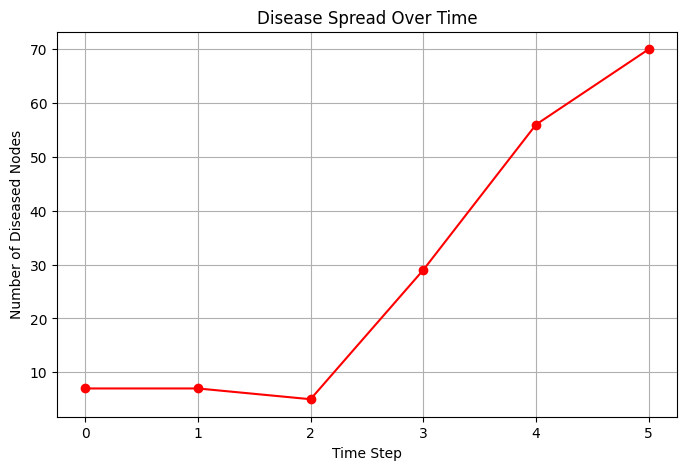

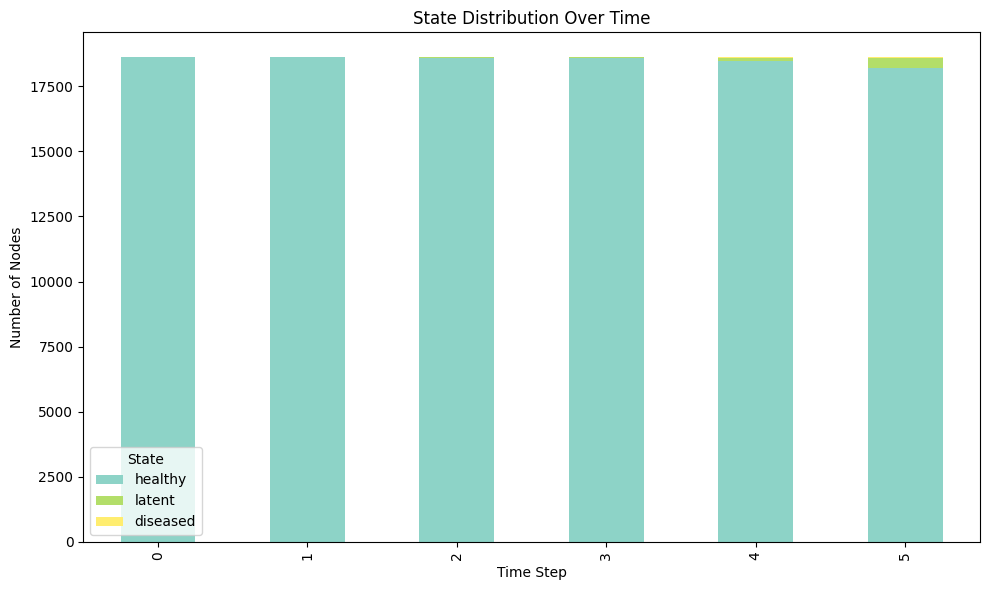

In [3]:
import matplotlib.pyplot as plt

def plot_disease_spread_over_time(simulation_results_df):
    # Group by step and state, then count
    grouped = simulation_results_df.groupby(["step", "state"]).size().reset_index(name='count')

    # Filter for diseased only
    diseased_df = grouped[grouped["state"] == "diseased"]

    plt.figure(figsize=(8, 5))
    plt.plot(diseased_df["step"], diseased_df["count"], marker='o', color='red')
    plt.title("Disease Spread Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Number of Diseased Nodes")
    plt.grid(True)
    plt.show()

def plot_state_distribution_over_time(simulation_results_df):
    """
    Creates a stacked bar plot showing how many nodes are in
    each state at each time step.
    """
    import seaborn as sns

    # Group and pivot to get counts of each state by step
    grouped = simulation_results_df.groupby(["step", "state"])["node"].count().reset_index()
    pivot_df = grouped.pivot(index="step", columns="state", values="node").fillna(0)

    # Sort columns so the plot has states in a certain order if desired
    # For instance: ["healthy", "latent", "diseased", "targeted_by_drug"]
    desired_order = [col for col in ["healthy", "latent", "diseased", "targeted_by_drug"] if col in pivot_df.columns]
    pivot_df = pivot_df[desired_order]

    pivot_df.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="Set3")

    plt.title("State Distribution Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Number of Nodes")
    plt.legend(title="State")
    plt.tight_layout()
    plt.show()

plot_disease_spread_over_time(simulation_results_df)
plot_state_distribution_over_time(simulation_results_df)
